# Hyperparameter tuning, using all 8 classifiers individually. After choosing the best parameters for each classifier, they will be input into the ensemble models. 

In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, log_loss
from yellowbrick.classifier import ClassificationReport
from mlxtend.evaluate import bias_variance_decomp
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import time
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import time
import matplotlib.pyplot as plt
%matplotlib inline

df_model = pd.DataFrame(pd.read_csv('../2019Data/df_Models2019.csv'))
X = df_model.iloc[:, :-1]
y = df_model.result
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(y_train.unique()) # binary classfication
X_train

[1 0]


,shoot_eff,score_op,off_rtg,def_rtg,sos,ie,efg_pct,to_poss,orb_pct,ft_rate,...,seed_7,seed_8,seed_9,seed_10,seed_11,seed_12,seed_13,seed_14,seed_15,seed_16
115,-0.010015,0.033993,3.206571,4.378437,-1.171866,-2.259006,0.008442,-0.000783,0.050527,-0.020508,...,0,0,0,0,0,0,0,0,0,0
538,0.037675,-0.001055,3.840748,-3.214371,7.055120,3.800816,0.027873,-0.004179,0.003576,-0.036029,...,255,0,0,1,0,0,0,0,0,0
1001,-0.004873,-0.009305,-1.534610,-1.284549,-0.250061,-0.332310,0.002933,0.029074,0.037908,-0.016763,...,0,0,0,0,0,0,0,0,1,0
495,-0.157367,-0.019756,-18.079543,-3.770023,-14.309520,-6.209820,-0.079887,0.044009,0.026061,0.024171,...,0,0,0,0,0,0,0,0,1,0
695,-0.202263,0.004986,-18.561373,-11.313391,-7.247982,-2.735033,-0.118989,0.035677,0.027175,-0.004217,...,0,255,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153,-0.073754,-0.002486,-7.657189,-1.039671,-6.617518,-5.570953,-0.041516,-0.021821,-0.070394,0.014995,...,0,0,0,0,1,0,0,0,0,0
722,-0.041333,0.018414,-1.919541,-9.793618,7.874077,7.669265,-0.010629,0.031115,0.090358,-0.029518,...,0,0,0,0,0,0,0,0,0,0
240,0.062410,-0.015004,4.761624,3.620824,1.140800,0.603223,0.045718,-0.033447,-0.087834,-0.089045,...,0,1,255,0,0,0,0,0,0,0
19,0.127432,-0.045477,7.336523,10.159544,-2.823020,-6.582444,0.053862,0.005880,-0.030863,0.056614,...,0,0,0,0,0,0,0,0,0,0


In [2]:
def create_pipe(X_train, clf, clf_label='clf'):
    """
    https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf
    Returns an sklearn model pipeline.
    """
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X_train.select_dtypes(include=['object']).columns
    preprocessor = ColumnTransformer(
        transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      (clf_label, clf)])
    return pipe
    
def clfy_report(clf, X_train, X_test, y_train, y_test, param_grid, clf_label='clf', cv=10):
    """
    Tune classifier hyperparameters and print metrics.
    """

    # Create pipeline steps for encoding categorical variables, feature scaling and normalization 
    pipe = create_pipe(X_train, clf, clf_label)
    
    # Instantiate grid search using 10-fold cross validation:
    # Learn relationship between predictors (basketball/tourney features) and outcome,
    # and the best parameters for defining such:
    search = RandomizedSearchCV(pipe, param_grid, cv=cv, n_iter=3).fit(X_train, y_train)



    
    # Predictions on the test set, new data that haven't been introduced to the model:
    predicted = search.predict(X_test)
    
    # Predictions as probabilities:
    probabilities = search.predict_proba(X_test)[:, 1]
    
    # Accuracy scores for the training and test sets:
    train_accuracy = search.score(X_train, y_train)
    test_accuracy = search.score(X_test, y_test)

    print('Best Parameters: {}\n'.format(search.best_params_))
    print('Training Accuracy: {:0.2}'.format(train_accuracy))
    print('Test Accuracy: {:0.2}\n'.format(test_accuracy))
    
    # Confusion matrix labels:
    labels = np.array([['true losses','false wins'], ['false losses','true wins']])
    
    # Model evaluation metrics:
    confusion_mtrx = confusion_matrix(y_test, predicted)
    auc = roc_auc_score(y_test, probabilities)
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    logloss = log_loss(y_test, search.predict_proba(X_test))
    
    # Plot all metrics in a grid of subplots:
    fig = plt.figure(figsize=(12, 12))
    grid = plt.GridSpec(2, 4, wspace=0.75, hspace=0.5)
    
    # Top-left plot - confusion matrix:
    plt.subplot(grid[0, :2])
    sns.heatmap(confusion_mtrx, annot=True, fmt="d") #, fmt='')
    plt.xlabel('Predicted Games')
    plt.ylabel('Actual Games');
    
    # Top-right plot - ROC curve:
    plt.subplot(grid[0, 2:])
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUROC: {:0.3}'.format(auc));
    
    # Bottom-left plot - support, or true predictions:
    plt.subplot(grid[1, :2])
    sns.countplot(y=predicted, orient='h')
    plt.yticks([1, 0], ('wins', 'losses'))
    plt.ylabel(''), plt.xlabel('Number Predicted');
    
    # Bottom-right plot - classification report:
    plt.subplot(grid[1, 2:])
    visualizer = ClassificationReport(search, classes=['losses', 'wins'])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    g = visualizer.poof();

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
Best Parameters: {'clf__kernel': 'rbf', 'clf__C': 10.0}

Training Accuracy: 0.9
Test Accuracy: 0.61



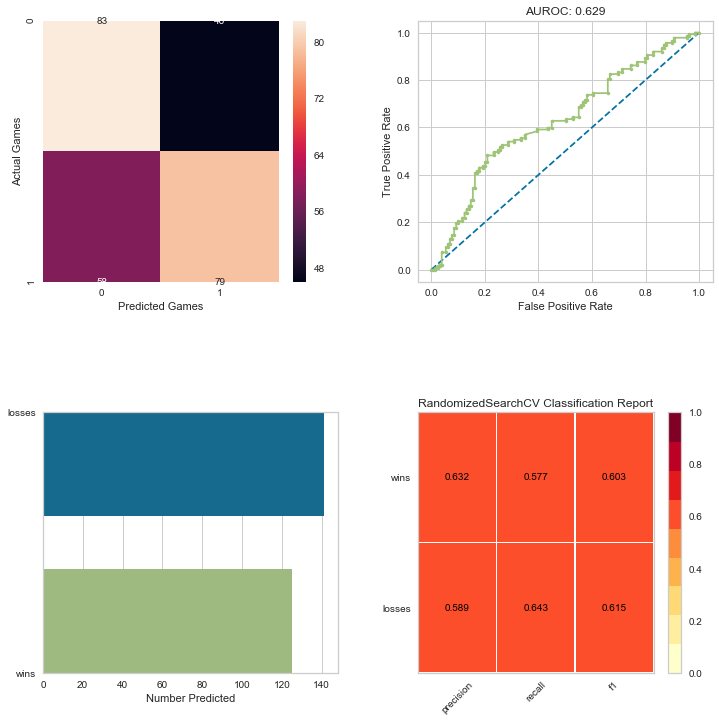

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Best Parameters: {'clf__n_estimators': 111, 'clf__max_features': 'sqrt'}

Training Accuracy: 1.0
Test Accuracy: 0.64



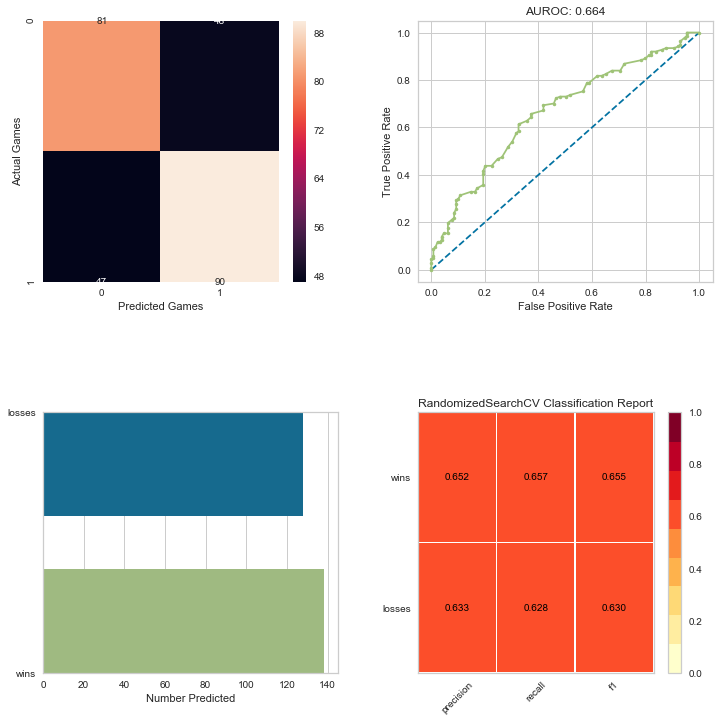

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Best Parameters: {'clf__penalty': 'none', 'clf__C': 10000000000.0}

Training Accuracy: 0.69
Test Accuracy: 0.67



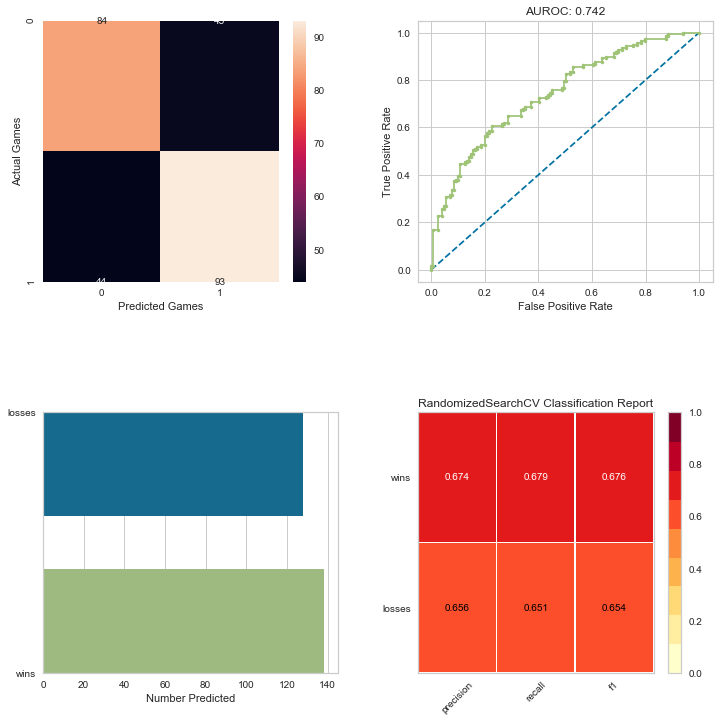

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
Best Parameters: {'clf__hidden_layer_sizes': (5, 10, 17)}

Training Accuracy: 0.78
Test Accuracy: 0.65



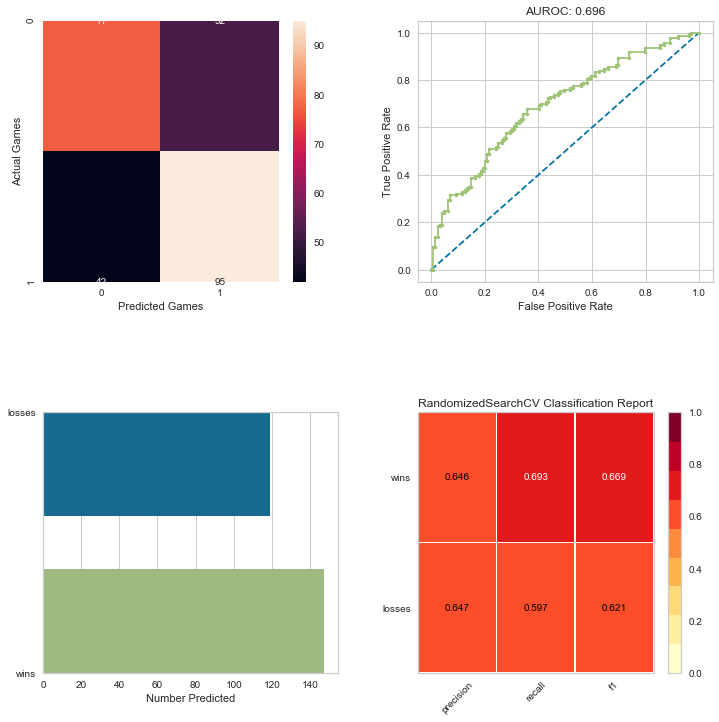

GaussianNB(priors=None, var_smoothing=1e-09)
Best Parameters: {'clf__var_smoothing': 1e-08}

Training Accuracy: 0.66
Test Accuracy: 0.64



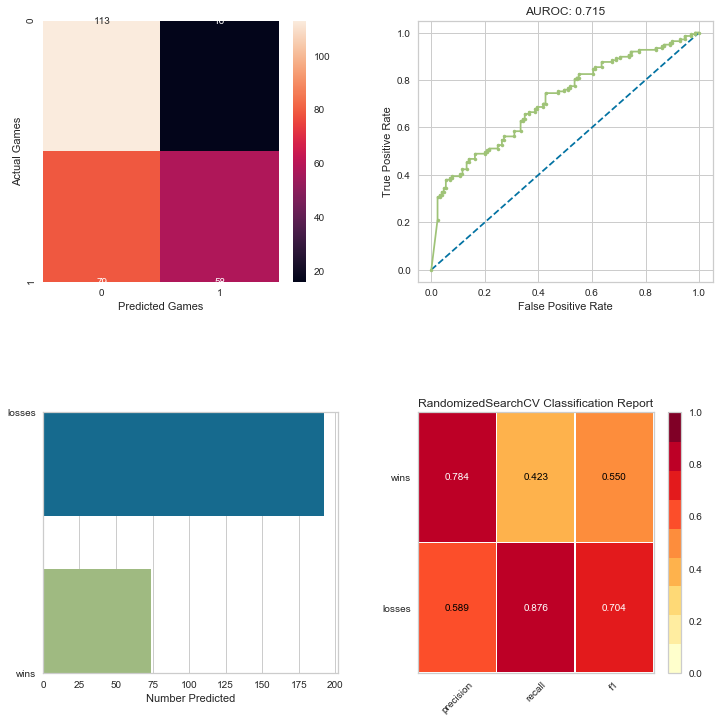

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
Best Parameters: {'clf__n_estimators': 144, 'clf__learning_rate': 0.5}

Training Accuracy: 0.79
Test Accuracy: 0.65



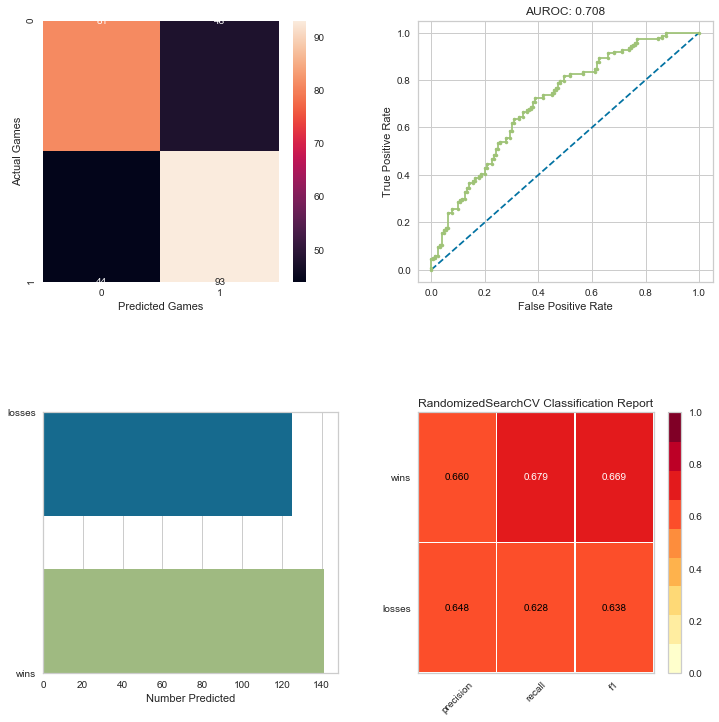

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Best Parameters: {'clf__n_estimators': 100, 'clf__learning_rate': 0.04}

Training Accuracy: 0.78
Test Accuracy: 0.65



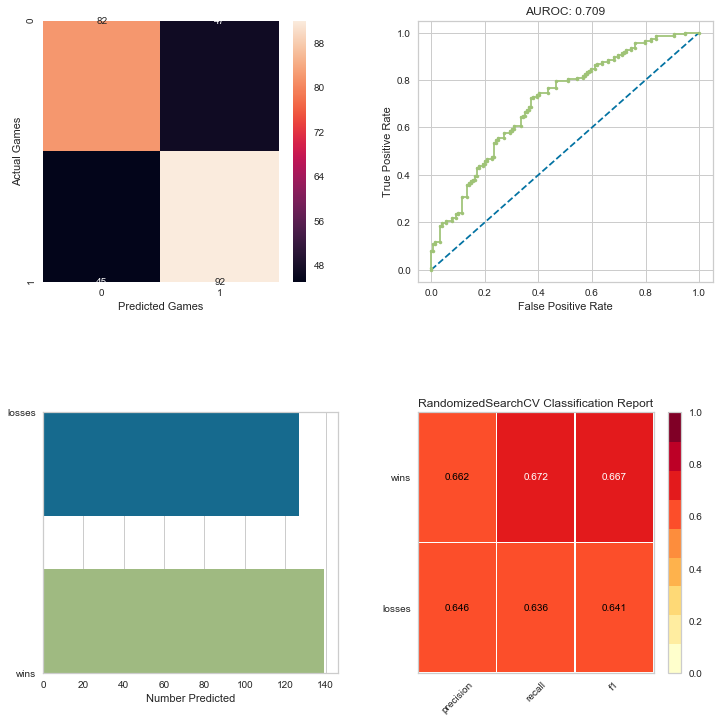

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Best Parameters: {'clf__max_depth': 5, 'clf__booster': 'gblinear'}

Training Accuracy: 0.68
Test Accuracy: 0.65



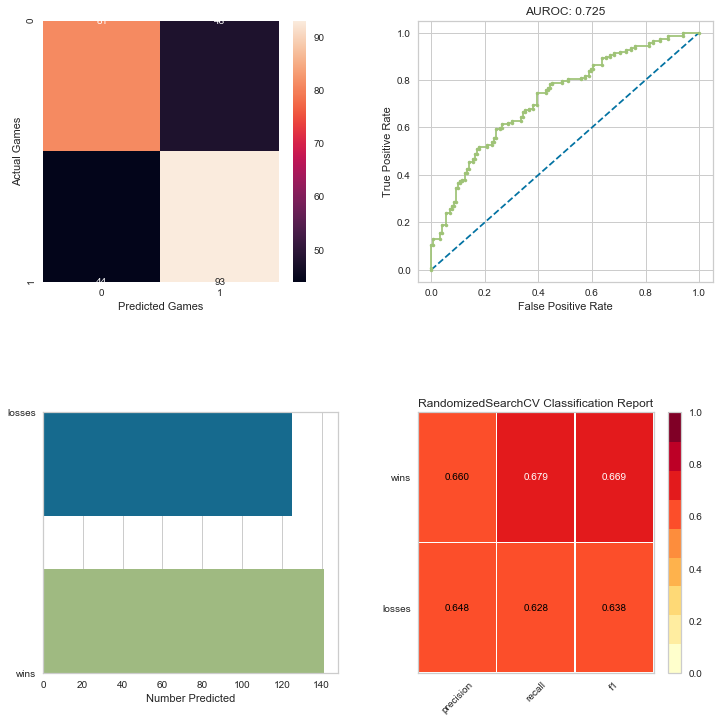

In [3]:
classifiers = [
    SVC(probability=True),
    RandomForestClassifier(),
    LogisticRegression(),
    MLPClassifier(max_iter=500), # to allow gaurenteed convergence. 
    GaussianNB(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier()
    ]


# clf__kernel
params=[
    { # SVC
        'clf__kernel': ['rbf', 'linear', 'sigmoid'],
        'clf__C': np.logspace(start=-10, stop=10, num=21) # default 1.0
    },
    { # RandomForestClassifier
        'clf__n_estimators': np.array(np.linspace(100,200,10, endpoint=True) , dtype=np.int32), # default 100
        'clf__max_features': ['sqrt', 'log2'] # The lower the greater the reduction of variance, but also the greater the increase in bias.
    },
    { # LogisticRegression
        'clf__C': np.logspace(start=-10, stop=10, num=21),
        'clf__penalty': ['none', 'l2']
    },
    { # Neural network multi-layered perceptron, MLPClassifier
      'clf__hidden_layer_sizes': tuple(map(tuple, np.random.randint(low=5, high=20, size=(10, 3)))) # from 5-20 nodes per 3 layers, 10 iterations
    },
    { # GaussianNB
        'clf__var_smoothing': [1e-8, 1e-9, 1e-10]
    },
    { # AdaBoostClassifier
        'clf__n_estimators': np.array(np.linspace(100,200,10, endpoint=True) , dtype=np.int32), # default 100
        'clf__learning_rate': np.linspace(0.5, 1.5, 10, endpoint=True) # default 1.0
    },
    { # GradientBoostingClassifier
        'clf__n_estimators': np.array(np.linspace(100,200,10, endpoint=True) , dtype=np.int32), # default 100
        'clf__learning_rate': np.linspace(0.02, 0.18, 9, endpoint=True) # default 0.1
    },
    { # XGBClassifier
#     'clf__learning_rate': np.logspace(start=0.01, stop=0.2, num=10, endpoint = True), # see last example in np.logspace documentation
    'clf__max_depth': [2,3,4,5],
    'clf__booster': ['gbtree', 'gblinear', 'dart']
    }
]

for i, classifier in enumerate(classifiers):
    print(classifier)
    clfy_report(classifier, X_train, X_test, y_train, y_test, param_grid=params[i], cv=20)


# Ensemble Methods: VotingClassifier, StackingClassifier. 

Reminder: High bias implies an underfit model, high variance implies an overfit model. 

## First, a bagging method using a VotingClassifier will be used to reduce the amount of variance in the model. Then, a boosting method using a StackingClassifier will be run comparatively to reduce bias. 

- ensemble averaging methods (VotingClassifier): average predictions to reduce variance. 
- ensemble boosting methods (StackingClassifier): base estimators are built sequentially and one tries to reduce the bias of the combined estimator.
- Bagging methods work best with strong and complex models (e.g. where the data points are unpredictable), in contrast with boosting methods which usually work best with weak models (e.g., shallow decision trees).
- Model with high bias pays very little attention to the training data and oversimplifies the model.
- High variance models pays attention to training data and does not generalize on the data which it hasn’t seen before.



# StackingClassifier/VotingClassifier Pipeline

In [4]:
def clfy_report_ensemble(ensemble_voting, X, y, cv=10):
    """
    Using an ensemble classifier, generate cross validated results. 
    Using StratifiedKFold to ensure that the classes are balanced equally in both
        training and testing, since some splits may be imbalanced. 
    """
    count_train_accuracy=0
    count_test_accuracy=0
    count_auc=0
    count_logloss=0
    count_fold=0
    
    skf=StratifiedKFold(n_splits=cv, random_state=None, shuffle=False)
    for train_index, test_index in skf.split(X, y):
        count_fold+=1
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        ensemble_voting.fit(X_train, y_train)

        predicted = ensemble_voting.predict(X_test)

        # Predictions as probabilities:
        probabilities = ensemble_voting.predict_proba(X_test)[:, 1]

        # Accuracy scores for the training and test sets:
        train_accuracy = ensemble_voting.score(X_train, y_train)
        test_accuracy = ensemble_voting.score(X_test, y_test)

        print('For fold: {}'.format(count_fold))
        print('Training Accuracy: {:0.2}'.format(train_accuracy))
        print('Test Accuracy: {:0.2}'.format(test_accuracy))

        # Confusion matrix labels:
        labels = np.array([['true losses','false wins'], ['false losses','true wins']])

        # Model evaluation metrics:
        confusion_mtrx = confusion_matrix(y_test, predicted)
        auc = roc_auc_score(y_test, probabilities)
        print('AUC: {:0.2}'.format(auc))
        fpr, tpr, thresholds = roc_curve(y_test, probabilities)
        logloss = log_loss(y_test, ensemble_voting.predict_proba(X_test))
        print('Logloss: {:0.2}\n'.format(logloss))
    
        # Update final counts.
        count_train_accuracy+=train_accuracy
        count_test_accuracy+=test_accuracy
        count_auc+=auc
        count_logloss+=logloss
    
    print('____________________________________')
    print('Final Cross-Validation Results:')
    print('____________________________________')
    print('Training Accuracy: {:0.2}'.format(count_train_accuracy/cv))
    print('Test Accuracy: {:0.2}'.format(count_test_accuracy/cv))
    print('AUC: {:0.2}'.format(count_auc/cv))
    print('Logloss: {:0.2}\n'.format(count_logloss/cv))

In [5]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns
preprocessor = ColumnTransformer(
    transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)])

# From hyperparameter tuning section above:
# Best Parameters: {'clf__kernel': 'sigmoid', 'clf__C': 100000000.0}
# Best Parameters: {'clf__n_estimators': 166, 'clf__max_features': 'sqrt'}
# Best Parameters: {'clf__penalty': 'l2', 'clf__C': 10000000.0}
# Best Parameters: {'clf__hidden_layer_sizes': (10, 19, 8)}
# Best Parameters: {'clf__var_smoothing': 1e-08}
# Best Parameters: {'clf__n_estimators': 177, 'clf__learning_rate': 0.7222222222222222}
# Best Parameters: {'clf__n_estimators': 188, 'clf__learning_rate': 0.04}
# Best Parameters: {'clf__max_depth': 4, 'clf__booster': 'gblinear'}
classifiers = [
    SVC(probability=True, kernel='sigmoid', C=100000000.0),         
    RandomForestClassifier(n_estimators=166, max_features='sqrt'),      
    LogisticRegression(penalty='l2', C=10000000.0),          
    MLPClassifier(max_iter=500, hidden_layer_sizes=(10, 19, 8)),   
    GaussianNB(var_smoothing=1e-08),                  
    AdaBoostClassifier(n_estimators=177, learning_rate=0.72),          
    GradientBoostingClassifier(n_estimators=188, learning_rate=0.04), 
    XGBClassifier(max_depth=4, booster='gblinear')             
    ]

pipeline_classifiers=[]
for i in range(0,len(classifiers)):
    pipeline_classifiers.append(Pipeline (steps=[('preprocessor', preprocessor),
        ('clf'+str(i+1), classifiers[i])]))
del classifiers
    
from sklearn.ensemble import VotingClassifier
ensemble_voting = Pipeline(steps=[('ensemble', VotingClassifier(estimators=[
    ('svc', pipeline_classifiers[0]), 
    ('rdf' , pipeline_classifiers[1]),
    ('lgr' , pipeline_classifiers[2]),
    ('mlp', pipeline_classifiers[3]),
    ('gau', pipeline_classifiers[4]),
    ('ada', pipeline_classifiers[5]), 
    ('gbt', pipeline_classifiers[6]),
    ('xgb', pipeline_classifiers[7])], 
                                voting='soft', 
                                # weights = [1,2,3], 
                                n_jobs=-1))])

# import pprint as pp
# pp.pprint(sorted(ensemble_voting.get_params().keys())) # used to specify ensemble params, below. 
clfy_report_ensemble(ensemble_voting, X, y, cv=10)

For fold: 1
Training Accuracy: 0.83
Test Accuracy: 0.65
AUC: 0.69
Logloss: 0.64

For fold: 2
Training Accuracy: 0.85
Test Accuracy: 0.58
AUC: 0.6
Logloss: 0.7

For fold: 3
Training Accuracy: 0.83
Test Accuracy: 0.6
AUC: 0.67
Logloss: 0.65

For fold: 4
Training Accuracy: 0.84
Test Accuracy: 0.64
AUC: 0.71
Logloss: 0.62

For fold: 5
Training Accuracy: 0.84
Test Accuracy: 0.61
AUC: 0.69
Logloss: 0.63

For fold: 6
Training Accuracy: 0.83
Test Accuracy: 0.67
AUC: 0.74
Logloss: 0.6

For fold: 7
Training Accuracy: 0.83
Test Accuracy: 0.53
AUC: 0.58
Logloss: 0.7

For fold: 8
Training Accuracy: 0.84
Test Accuracy: 0.67
AUC: 0.73
Logloss: 0.62

For fold: 9
Training Accuracy: 0.84
Test Accuracy: 0.75
AUC: 0.84
Logloss: 0.53

For fold: 10
Training Accuracy: 0.83
Test Accuracy: 0.83
AUC: 0.91
Logloss: 0.47

____________________________________
Final Cross-Validation Results:
____________________________________
Training Accuracy: 0.84
Test Accuracy: 0.65
AUC: 0.72
Logloss: 0.62



In [14]:
classifiers = [
    ('svc',  SVC(probability=True, kernel='sigmoid', C=100000000.0)        ),
    ('rdf' ,     RandomForestClassifier(n_estimators=166, max_features='sqrt')     ),
    ('lgr' ,     LogisticRegression(penalty='l2', C=10000000.0)         ),
    ('mlp',      MLPClassifier(max_iter=500, hidden_layer_sizes=(10, 19, 8))   ),
    ('gau',      GaussianNB(var_smoothing=1e-08)                  ),
    ('ada',      AdaBoostClassifier(n_estimators=177, learning_rate=0.72)          ),
    ('gbt',      GradientBoostingClassifier(n_estimators=188, learning_rate=0.04) ),
    ('xgb',      XGBClassifier(max_depth=4, booster='gblinear')  )
    ]

from sklearn.ensemble import StackingClassifier
stack_clf = StackingClassifier(estimators=classifiers, final_estimator=LogisticRegression())
pipe_stack_clf = Pipeline(steps=[('preproc', preprocessor), ('stack', stack_clf)])
clfy_report_ensemble(pipe_stack_clf, X, y, cv=10)

For fold: 1
Training Accuracy: 0.64
Test Accuracy: 0.66
AUC: 0.72
Logloss: 0.62

For fold: 2
Training Accuracy: 0.6
Test Accuracy: 0.62
AUC: 0.63
Logloss: 0.69

For fold: 3
Training Accuracy: 0.62
Test Accuracy: 0.62
AUC: 0.69
Logloss: 0.64

For fold: 4
Training Accuracy: 0.66
Test Accuracy: 0.65
AUC: 0.71
Logloss: 0.62

For fold: 5
Training Accuracy: 0.67
Test Accuracy: 0.58
AUC: 0.68
Logloss: 0.63

For fold: 6
Training Accuracy: 0.68
Test Accuracy: 0.69
AUC: 0.78
Logloss: 0.57

For fold: 7
Training Accuracy: 0.69
Test Accuracy: 0.57
AUC: 0.61
Logloss: 0.71

For fold: 8
Training Accuracy: 0.69
Test Accuracy: 0.69
AUC: 0.75
Logloss: 0.6

For fold: 9
Training Accuracy: 0.53
Test Accuracy: 0.73
AUC: 0.84
Logloss: 0.54

For fold: 10
Training Accuracy: 0.66
Test Accuracy: 0.83
AUC: 0.93
Logloss: 0.45

____________________________________
Final Cross-Validation Results:
____________________________________
Training Accuracy: 0.64
Test Accuracy: 0.66
AUC: 0.73
Logloss: 0.61



# Loss, Bias, Variance

In [41]:
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        stack_clf, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), 
        loss='0-1_loss')

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 0.369
Average bias: 0.365
Average variance: 0.131


In [39]:
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
#         ensemble_voting[0], np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), 
    VotingClassifier(estimators=[
        classifiers[0], 
        classifiers[1],
        classifiers[2],
        classifiers[3],
        classifiers[4],
        classifiers[5], 
        classifiers[6],
        classifiers[7]], 
                        voting='soft', 
                        # weights = [1,2,3], 
                        n_jobs=-1),
        np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), 
        loss='0-1_loss')

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 0.347
Average bias: 0.308
Average variance: 0.099


# Results:

#### From these results, the both of the VotingClassifier and StackingClassifier models built have:
- very low variance  (~0.10 - 0.14)
- low-moderate loss (~0.31 - 0.34)
- low-moderate bias (~0.30 - 0.32)  </ul>
The results above implies that the final model needs to use the StackingClassifier, to lower bias. However, the 10-fold cross-validated accuracy is around the same for the VotingClassifier (Training Accuracy: 0.82, Test Accuracy: 0.69) compared to the StackingClassifier (Training Accuracy: 0.64, Test Accuracy: 0.7). 
### Therefore, either VotingClassifier or StackingClassifier could be used as the primary prediction model.

# Create a bracket using both methods. 

In [31]:
df_predict = pd.read_csv('../2019Data/SampleSubmissionStage2.csv')
df_predict.head()

,ID,Pred
0,2019_1101_1113,0.5
1,2019_1101_1120,0.5
2,2019_1101_1124,0.5
3,2019_1101_1125,0.5
4,2019_1101_1133,0.5


In [32]:
def get_year_team1_team2(ID):
    """Return a tuple with the year, team1 and team2
    for each ID in the sample submission file of possible matches."""
    return (int(x) for x in ID.split('_'))

In [36]:
df_features = pd.read_csv('../2019Data/df_features.csv')
diff = []
data = []

for i, row in df_predict.iterrows():

    year, team1, team2 = get_year_team1_team2(row.ID)

    # Save 2018 stats/features for the first ID:
    team1 = df_features[(df_features['Season'] == year) & (df_features['TeamID'] == team1)].values[0]

    # Save 2018 stats/features for the first ID:
    team2 = df_features[(df_features['Season'] == year) & (df_features['TeamID'] == team2)].values[0]

    diff = team1 - team2

    data.append(diff)

n_poss_games = len(df_predict)
columns = df_features.columns.get_values()
final_predictions = pd.DataFrame(np.array(data).reshape(n_poss_games, np.array(data).shape[1]), columns=(columns))
final_predictions.drop(['Season', 'TeamID'], inplace=True, axis=1)

# StackingClassifier Bracket Predictions

In [37]:
final_predictions

,shoot_eff,score_op,off_rtg,def_rtg,sos,ie,efg_pct,to_poss,orb_pct,ft_rate,...,seed_7,seed_8,seed_9,seed_10,seed_11,seed_12,seed_13,seed_14,seed_15,seed_16
0,0.003268,-0.001377,0.302363,-3.971732,4.274095,2.672336,-0.000353,-0.016069,-0.035995,-0.034463,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.0
1,-0.030586,-0.012555,-4.541209,-4.272320,-0.268889,0.744387,-0.020481,-0.016317,-0.052618,0.026103,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.047420,-0.030555,1.126196,-5.669472,6.795668,4.906565,0.017256,-0.013190,-0.069138,0.039885,...,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.096187,0.003068,-8.892495,-4.129957,-4.762539,-2.319036,-0.062152,0.015443,0.020077,0.044473,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.0
4,0.062758,0.002995,6.704054,-1.750449,8.454502,5.918451,0.031297,-0.004203,0.011545,0.014282,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,-0.107595,-0.034156,-14.551158,-4.024504,-10.526655,-3.798225,-0.065026,0.039904,-0.009193,0.043474,...,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2274,-0.057442,-0.010999,-7.142456,-5.746928,-1.395528,-0.277191,-0.033686,0.037313,0.042969,0.026688,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
2275,-0.150200,0.004743,-14.004756,-3.518796,-10.485960,-4.100628,-0.079492,-0.012341,-0.053488,-0.020104,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2276,-0.100047,0.027900,-6.596054,-5.241220,-1.354834,-0.579594,-0.048152,-0.014932,-0.001326,-0.036890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0


StackingClassifier fit on data.


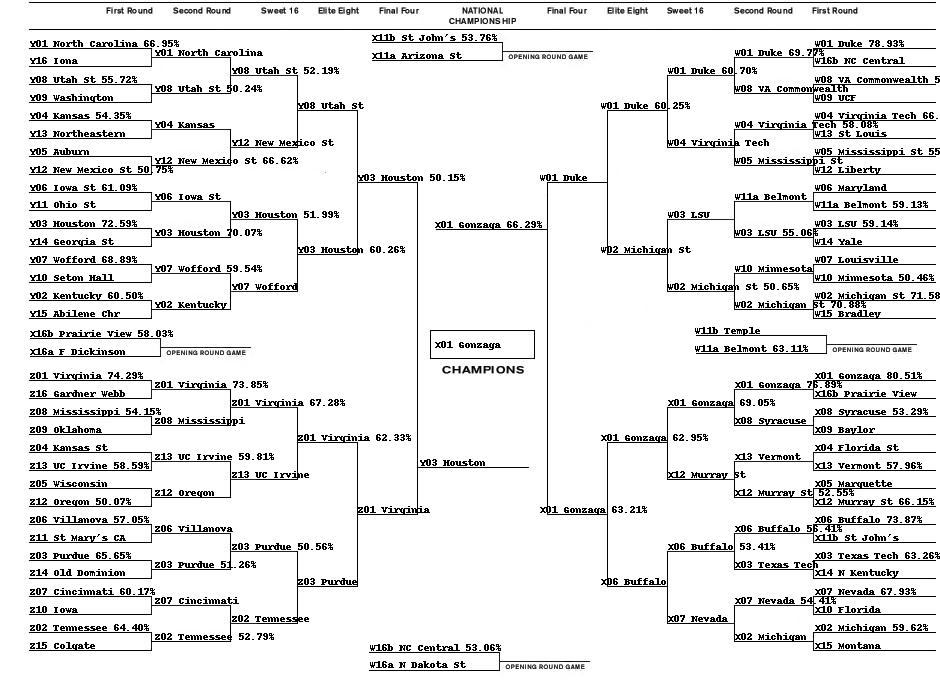

In [38]:
stack_clf.fit(X,y)
print("StackingClassifier fit on data.")
predictions = stack_clf.predict_proba(final_predictions)[:, 1]
clipped_predictions = np.clip(predictions, 0.05, 0.95)
df_predict.Pred = clipped_predictions
df_predict.to_csv('search_stk.csv', index=False)

from bracketeer import build_bracket
b = build_bracket(
        outputPath='search_stk.png', # in /Ryan
        submissionPath='search_stk.csv',
        teamsPath='../2019Data/Stage2DataFiles/Teams.csv',
        seedsPath='../2019Data/Stage2DataFiles/NCAATourneySeeds.csv',
        slotsPath='../2019Data/Stage2DataFiles/NCAATourneySlots.csv',
        year=2019
)
from IPython.display import Image
Image(filename='search_stk.png')

# VotingClassifier Bracket Predictions

VotingClassifier fit on data.


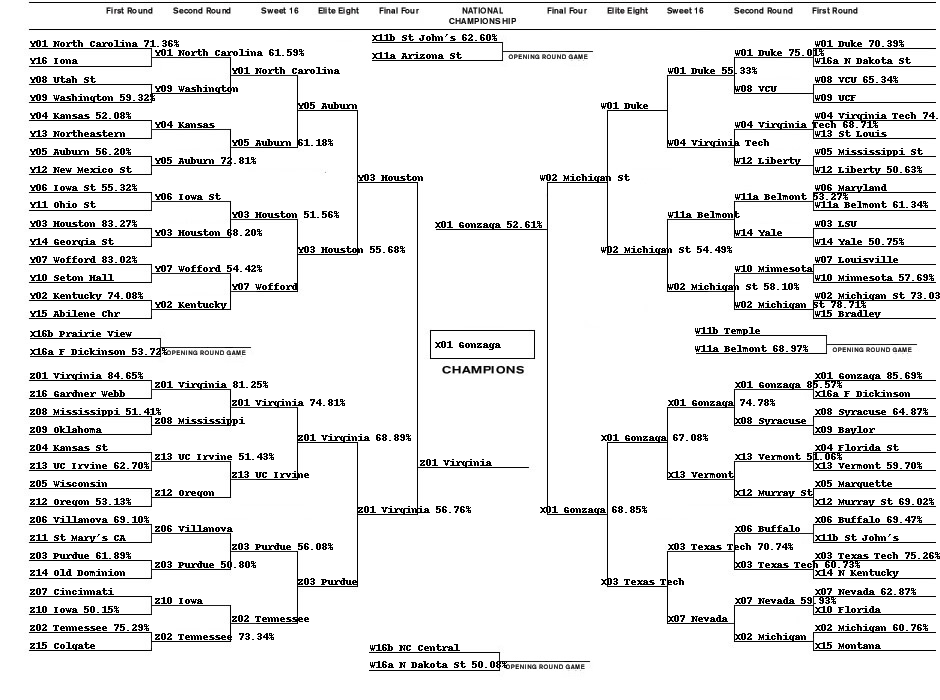

In [40]:
ensemble_voting.fit(X,y)
print("VotingClassifier fit on data.")
predictions = ensemble_voting.predict_proba(final_predictions)[:, 1]
clipped_predictions = np.clip(predictions, 0.05, 0.95)
df_predict.Pred = clipped_predictions
df_predict.to_csv('search_voting.csv', index=False)

from bracketeer import build_bracket
b = build_bracket(
        outputPath='search_voting.png', # in /Ryan
        submissionPath='search_voting.csv',
        teamsPath='../2019Data/Stage2DataFiles/Teams.csv',
        seedsPath='../2019Data/Stage2DataFiles/NCAATourneySeeds.csv',
        slotsPath='../2019Data/Stage2DataFiles/NCAATourneySlots.csv',
        year=2019
)
from IPython.display import Image
Image(filename='search_ens.png')